### 3. lecke: Sejtautomata készítése

**FELADAT** Szimuláljuk le egy sejtkolónia életét, a következő szabályok alapján:
1. A sejt elpusztul, ha kettőnél kevesebb szomszédja van (elszigetelődés) 
2. A sejt túléli a kört, ha két vagy három szomszédja van.
3. A sejt elpusztul, ha háromnál több szomszédja van(túlnépesedés).
4. Új sejt születik minden olyan cellában, melynek környezetében pontosan három sejt található.

![Szabályok](game-of-life-rules.jpg)

Wikipedia:
https://en.wikipedia.org/wiki/Conway's_Game_of_Life

Epic:
https://www.youtube.com/watch?v=C2vgICfQawE

Színes:
https://youtu.be/WqNockPqPBg

Kapcsolat a hackerek világával:
http://www.catb.org/hacker-emblem/faqs.html
![Glider](https://upload.wikimedia.org/wikipedia/commons/4/45/Glider.svg)

## Fájlból olvasás

Az első szabályhoz íme a bemeneti fájlunk

In [1]:
!cat 1.in

0 0 0
0 1 0
0 0 1


Megnyitjuk a fájlt, és beolvassuk a tartalmát. Ez a régi fajta, C -s, C++ -os megközelítés:

In [2]:
def fread(file_name):
    data = None
    print('1. start')
    try:
        f = open(file_name,"r")
        if f:
            print('2. olvasas')
            data = f.read()
    except FileNotFoundError:
        pass
    print('3. vege')
    return data

In [3]:
d = fread("1.in")
print('4. data:')
print(d)

1. start
2. olvasas
3. vege
4. data:
0 0 0
0 1 0
0 0 1



In [4]:
d = fread("1x.in")
print('data:')
print(d)

1. start
3. vege
data:
None


A with (pythonos megközelítés) sokkal átláthatóbb:

In [5]:
def fread(file_name):
    data = None
    print('1. start')
    try:
        with open(file_name,"r") as file:
            print('2. olvasas')
            data = file.read()
    except FileNotFoundError:
        pass
    print('3. vege')
    return data

In [6]:
d=fread("1.in")
print('4. data:')
print(d)

1. start
2. olvasas
3. vege
4. data:
0 0 0
0 1 0
0 0 1



In [7]:
d=fread("1x.in")
print('4. data:')
print(d)

1. start
3. vege
4. data:
None


In [8]:
def fread(file_name):
    data = None
    try:
        with open(file_name,"r") as file:
            data = file.read()
    except FileNotFoundError:
        pass
    return data

Ha viszont később, a többi cellában is szeretnénk használni a beolvasott adatokat, akkor muszáj egy változót létrehozni

In [9]:
data = fread("1.in")
data

'0 0 0\n0 1 0\n0 0 1\n'

Ez egy string lesz, amit még fel kell darabolnunk a sorvégek alapján ... miután lecsupaszítottuk

In [10]:
stripped = data.strip()
stripped

'0 0 0\n0 1 0\n0 0 1'

In [11]:
lines = stripped.split("\n")
lines

['0 0 0', '0 1 0', '0 0 1']

Tudjuk ezt gyorsabban is, és sokkal effektívebben:

In [12]:
with open("1.in") as f:
    lines = f.readlines()
lines

['0 0 0\n', '0 1 0\n', '0 0 1\n']

Ha még a sorokat is feldaraboljuk a space alapján, akkor a következőt kapjuk

In [13]:
for line in lines:
    print(line.split(' '))

['0', '0', '0\n']
['0', '1', '0\n']
['0', '0', '1\n']


... a strip segít, ha space alapján splitelünk ...

In [14]:
for line in lines:
    print(line.strip().split(' '))

['0', '0', '0']
['0', '1', '0']
['0', '0', '1']


... vagy egyszerűen whitespace alapján splitelünk

In [15]:
for line in lines:
    print(line.split())

['0', '0', '0']
['0', '1', '0']
['0', '0', '1']


Ha minden egyes sorban kiírjuk a talált számokat egyenként:

In [16]:
for line in lines:
    for cell in line.split():
        print(cell)

0
0
0
0
1
0
0
0
1


In [17]:
r = []
for line in lines:
    for cell in line.split():
        r.append(cell)
r

['0', '0', '0', '0', '1', '0', '0', '0', '1']

Nézzük, hol vannak 1-esek:

In [18]:
y = 0
for line in lines:
    x = 0
    for cell in line.split():
        if cell == '1':
            print('({}, {})'.format(x,y))
        x += 1
    y += 1

(1, 1)
(2, 2)


Gyűjtsük össze tuple-ök listájába, hol vannak 1-esek:

In [19]:
cell_pos_list = []
y = 0
for line in lines:
    x = 0
    for cell in line.split():
        if cell == '1':
            cell_pos_list.append((x,y))
        x += 1
    y += 1
cell_pos_list

[(1, 1), (2, 2)]

Gábor kifogásolta, hogy a pozíciókkal megyünk tovább. Egyrészt a videós példákban láttuk, hogy elég ritkán vannak a sejtek, másrészt a szabályok implementációja során belefutunk pár olyan problémába, amikor ez a fajta absztrakció nagyon jól jön majd, és a python beépített in-kulcsszava, a pozíciók listában tárolása és a pozíciók tuple-természete segít a feladatunk megoldásában. 

Azt se felejtsük el, hogy a definíció alapján egy végtelen 2D-s síkon vagyunk, és nem szeretnénk magunkat lekorlátozni egy előre foglalt mátrixba(amit aztán később újra kell foglalnunk, hogyha a sejtjeink kifejlődnek a határain kívülre). A rajzolásnál látjuk csak igazán, hogy mindig csak a világunk egy részét rajzoljuk csak ki, a többi részével nem törődünk.

Szükségünk lesz a cellák pozíciójának szélső értékeire:

In [20]:
def get_extremes(cells):
    xmin = 0
    ymin = 0
    xmax = 0
    ymax = 0
    for x,y in cells:
        if x < xmin:
            xmin = x
        if xmax < x:
            xmax = x
        if y < ymin:
            ymin = x
        if ymax < y:
            ymax = y
    return (xmin, ymin, xmax, ymax)

Egy kis rajzolás is segíthet, kirajzoljuk a sejtek helyeit, majd végigmegyünk a sejtek pozícióin

In [21]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
cellsize = 20

def draw_cells(cells):
    xmin, ymin, xmax, ymax = get_extremes(cells)
    im_size = tuple(cellsize*t+1 for t in (xmax - xmin + 1, ymax - ymin + 1))
    im = Image.new("RGBA",size=im_size)
    draw = ImageDraw.Draw(im)
    for x in range(0, im_size[0]+1, cellsize):
        draw.line((x,0,x,im.size[1]), fill="grey")
    for y in range(0, im_size[1]+1, cellsize):
        draw.line((0,y,im.size[0],y), fill="grey")
    for cell in cells:
        cellx, celly = cell
        cx = cellx * cellsize
        cy = celly * cellsize
        draw.rectangle((cx+2,cy+2,cx+cellsize-2, cy+cellsize-2), fill="black")
    return im

 ...és minden pozícióra rajzolunk egy sejtet:

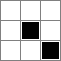

In [22]:
draw_cells(cell_pos_list)

## Fejlődnek a sejtjeink

**FELADAT** Próbáljátok leimplementálni mind a négy fenti szabályt az alábbi függvényben!

In [23]:
def evolve(cells):
    new_cells = []
    
    #TODO
    new_cells = cells 
    new_cells.append((5,2))
    
    return new_cells

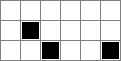

In [24]:
new_generation = evolve(cell_pos_list)
draw_cells(new_generation)

## Fájlba írás

In [25]:
xmin, ymin, xmax, ymax = get_extremes(cell_pos_list)
lines = []
for y in range(ymin, ymax+1):
    linearr = []
    for x in range(xmin, xmax+1):
        if (x,y) in new_generation:
            linearr.append("1")
        else:
            linearr.append("0")
        #linearr.append("1" if (x,y) in new_generation else "0")
    line = ' '.join(linearr)
    lines.append(line)
print(lines)
data = "\n".join(lines)  
data

['0 0 0 0 0 0', '0 1 0 0 0 0', '0 0 1 0 0 1']


'0 0 0 0 0 0\n0 1 0 0 0 0\n0 0 1 0 0 1'

In [26]:
with open("1.out","w") as f:
    f.write(data)

In [27]:
!cat 1.out

0 0 0 0 0 0
0 1 0 0 0 0
0 0 1 0 0 1

**FELADAT** Javasoljatok új formátumot a sejtek pozícióinak leírására, amit könnyebb felolvasni egy szöveges fájlból, és könnyebb kiírni fájlba, és még kevesebb helyet is foglal, mint a mostani! 